In [3]:
# -*- coding: utf-8 -*-
import json
import numpy as np
import openturns as ot
import os
import pylab as plt
import pickle 

from pce_ot import *

plt.rcParams['text.usetex'] = True
plt.rcParams['figure.dpi']= 500

# Import Data

In [4]:
### DATA IMPORT ###
dataset_hl = ot.Sample.ImportFromCSVFile('../../data/SG_MC_HL.csv')

In [5]:
### TIME INDICES ### 
operation_time = np.load('../../data/SG_time.npy')

In [6]:
### INPUT SAMPLE ###
inputSample = dataset_hl[:,0:7]

In [7]:
### OUTPUT SAMPLE ###
outputSample = dataset_hl[:,7:]

In [8]:
### PARAMETERS OF THE STEAM GENERATOR ###
input_dic = {}
input_dic['SG'] = json.load(open('../../data/SG_cleaning_conditioning.json'))

In [9]:
### COLOR SCHEME FOR CHEMICAL CONDITIONING ###
colors_chem_cond = {'C1': {'name': r'$\chi_{1}$', 'low': 'lightgreen', 'high': 'forestgreen'},
                    'C2': {'name': r'$\chi_{2}$', 'high': 'slateblue'}}

### COLOR SCHEME FOR PCE OPTIMIZATION ###
colors_pce_opt = ['tomato', 'darkred', 'blue', 'gold', 'hotpink', 'magenta']

In [10]:
### DISTRIBUTIONS OF THE INPUT PARAMETERS ###
distribution_alpha = ot.Normal(101.6612, 4.0)
distribution_alpha.setDescription([r"$\alpha$"])
#
distribution_beta = ot.Normal(0.0233, 0.0005)
distribution_beta.setDescription([r"$\beta$"])
#
distribution_epsilon_e = ot.Triangular(0.2, 0.3, 0.5)
distribution_epsilon_e.setDescription([r"$\epsilon_e$"])
#
distribution_epsilon_c = ot.Triangular(0.0, 0.05, 0.3)
distribution_epsilon_c.setDescription([r"$\epsilon_c$"])
#
dp_factor = 1.0e-6
distribution_dp = ot.Triangular(0.5 * dp_factor, 5.0 * dp_factor, 10.0 * dp_factor)
distribution_dp.setDescription([r"$d_p$"])
#
distribution_gamma_p0 = ot.Triangular(1.0e-09, 4.5e-09, 8.0e-09)
distribution_gamma_p0.setDescription([r"$\Gamma_p(0)$"])
#
distribution_av = ot.Triangular(0.1e-4, 7.8e-4, 12e-4)
distribution_av.setDescription([r"$a_v$"])
#
distributionList = [
    distribution_alpha,
    distribution_beta,
    distribution_epsilon_e,
    distribution_epsilon_c,
    distribution_dp,
    distribution_gamma_p0,
    distribution_av,
]
distribution = ot.ComposedDistribution(distributionList)

labels = [marginal.getDescription()[0] for marginal in distributionList]

# 3.1 Time-dependent surrogate modeling via polynomial chaos expansions

In [11]:
### PCE basis ###
multivariateBasis = ot.OrthogonalProductPolynomialFactory(
    distributionList
)

## Distribution of the $\overline{Q^{2}}$ for different degrees $p$ as a function of $q$-norm

In [12]:
### PCE HYPERPARAMETERS ###
q_norm = [round(0.1 * i, 1) for i in range(1,11)]
degrees = [i for i in range(1, 11)]

In [13]:
### NUMBER OF PERMUTATIONS ###
calculate = False
number_attempts = 5

In [14]:
if calculate: 
    q2_deg_qnorm = []
    for deg in degrees:
        q2_deg_qnorm.append(compute_sample_Q2_q_norm(inputSample, outputSample[:,:], distribution, number_attempts, q_norm, deg))
    #Save the realizations of the Q2 samples
    with open("Q2_q_norm_HL.pkl", "wb") as f:
        pickle.dump(q2_deg_qnorm, f)    
else:
    if os.path.getsize('../../data/Q2_q_norm_deg_HL.pkl') > 0:      
        with open('../../data/Q2_q_norm_deg_HL.pkl', "rb") as f:
            unpickler = pickle.Unpickler(f)
            q2_deg_qnorm = unpickler.load()

In [15]:
### FOCUS ON THE BEST DEGREES p = 4 , ... , 6 ###
q2_deg_opt_qnorm = np.asarray(q2_deg_qnorm[3: 9])
deg_opt = degrees[3: 9]

In [16]:
### Q-NORMS WITH THE SMALLEST Q2 VARIABILITY AND BEST MEDIAN FOR EACH DEGREE ###
q_opt = [0.7, 0.7, 0.9, 0.7, 0.7, 0.6]

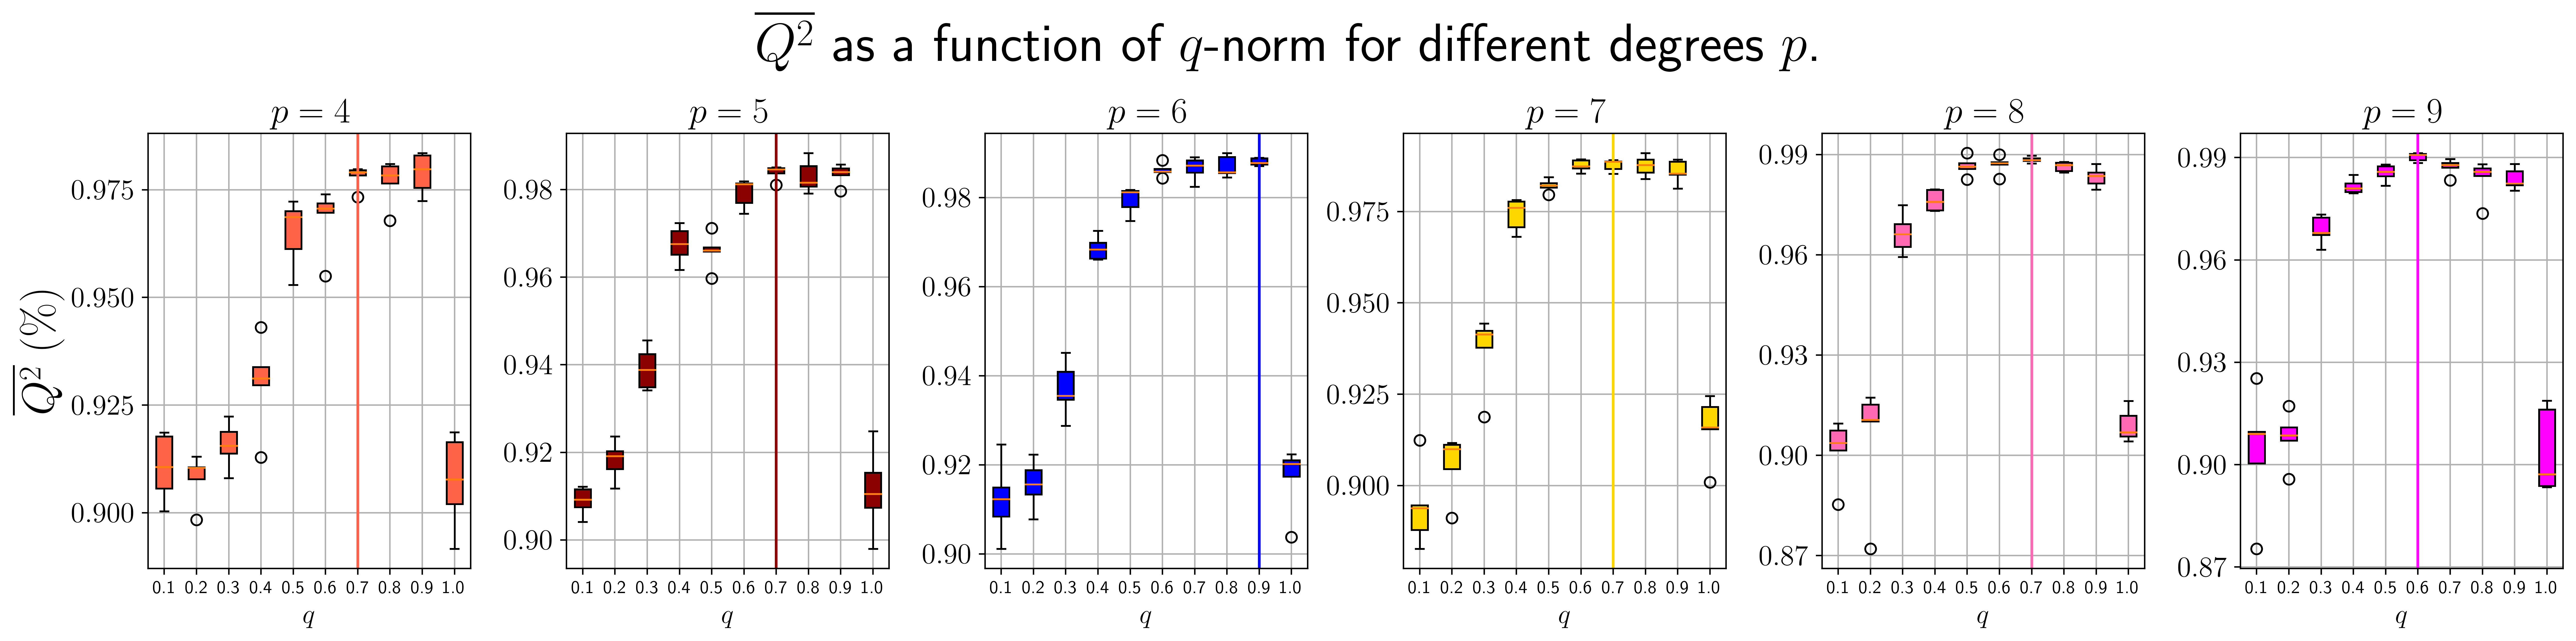

In [17]:
### FIG. 6 ###

fig, ax = plt.subplots(1,6,figsize=(20,5), layout='tight')
colors_bpl=[['tomato']*10, ['darkred']*10, ['blue']*10, ['gold']*10, ['hotpink']*10, ['magenta']*10]

for i in range(6):
   bpl = ax[i].boxplot(q2_deg_opt_qnorm[i], patch_artist=True)
   for patch, color in zip(bpl['boxes'], colors_bpl[i]):
         patch.set_facecolor(color)
   ax[i].set_xlabel(r"$q$", fontsize=15)
   ax[i].set_xticks([i for i in range(1,11)], q_norm)
   ax[i].yaxis.set_major_locator(plt.MaxNLocator(5))
   ax[i].yaxis.grid(True)
   ax[i].xaxis.grid(True)    
   for label in (ax[i].get_yticklabels()):
      label.set_fontsize(16) 
   ax[i].set_title(r"$p = {}$".format(deg_opt[i]), fontsize=20)
   ax[i].axvline(x=q_opt[i]*10, color=colors_pce_opt[i])
ax[0].set_ylabel(r"$\overline{Q^2}\;(\%)$", fontsize=25)

fig.suptitle(r"$\overline{Q^2}$ as a function of $q$-norm for different degrees $p$.", fontsize=30)
fig.savefig('../../plots/PCE/TPD_PCE_Q2_validation.pdf', format='pdf', bbox_inches='tight')
fig.savefig('../../plots/PCE/TPD_PCE_Q2_validation.png', format='png', bbox_inches='tight')

## Construction of the optimal PCEs

In [16]:
pce_s = []

for i in range(len(deg_opt)):
    q = q_opt[i]
    totalDegree = deg_opt[i]

    enumerateFunction = ot.HyperbolicAnisotropicEnumerateFunction(inputSample.getDimension(), q)
    multivariateBasis = ot.OrthogonalProductPolynomialFactory([distribution.getMarginal(i) for i in range(distribution.getDimension())], enumerateFunction
    )

    split_fraction = 0.75

    training_sample_size = inputSample.getSize()

    X_train = ot.Sample(inputSample)
    Y_train = ot.Sample(outputSample)
    split_index = int(split_fraction * training_sample_size)

    X_test = X_train.split(split_index)
    Y_test = Y_train.split(split_index)

    chaosResult = ComputeSparseLeastSquaresChaos(
            X_train, Y_train, multivariateBasis, totalDegree, distribution
        )
    
    if i == 3:
        pce_s.append(chaosResult.getMetaModel())
        # SAVE THE REALIZATION OF THE OPTIMAL PCE
        with open("PCE_metamodel.pkl", "wb") as f:
            pickle.dump(chaosResult, f)   
    else:
        pce_s.append(chaosResult.getMetaModel())

# Variation of $t\mapsto Q^2(t)$ for different polynomials

In [15]:
q2_s = []
inputTest, outputTest = inputSample[750:, :], outputSample[750:, :]
for p in pce_s:
    val = ot.MetaModelValidation(inputTest, outputTest, p)
    q2_s.append(val.computePredictivityFactor())

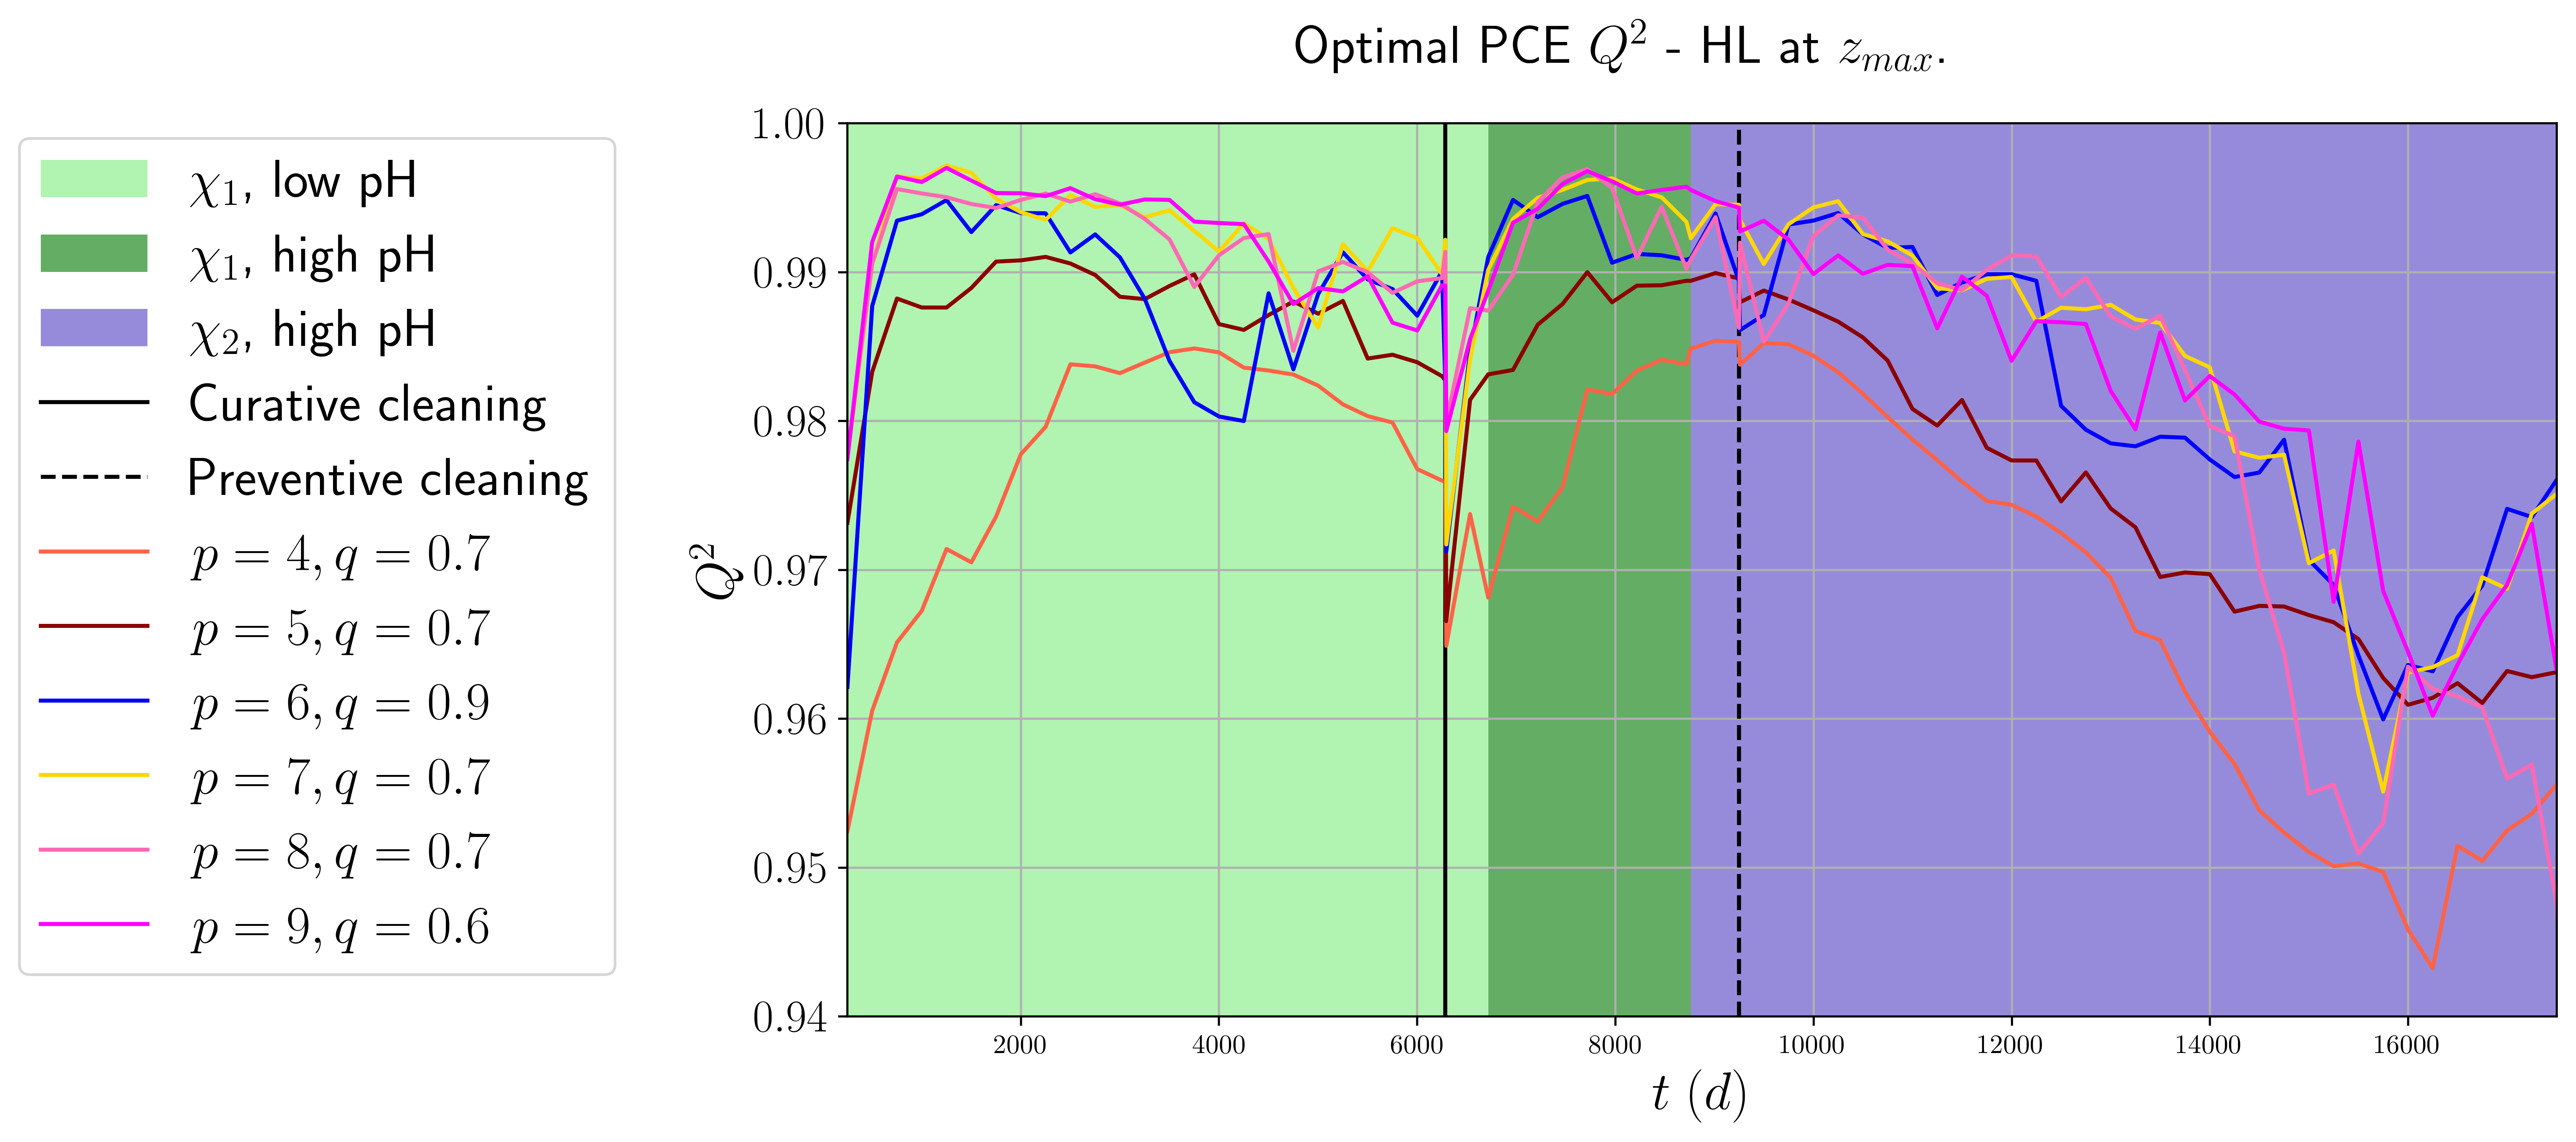

In [101]:
### FIG 7 ###

fig, axs = plt.subplots((1,1), figsize=(10,6), layout='tight')

#Chemical conditioning
cond = input_dic['SG']['chemistry']['conditioning']
for k in range(len(cond)):
    if k == len(cond)-1:
        t_i, t_f = cond[k]['time']/24, max(operation_time)
    else:
        t_i, t_f = cond[k]['time']/24, cond[k+1]['time']/24
    c = cond[k]
    typ = colors_chem_cond[c['type']]
    col = typ[str(c['ph'])]
    axs.axvspan(t_i, t_f, facecolor=col, alpha=0.7, label='{0}, {1} pH'.format(typ['name'], c['ph']))

#Cleaning dates
nett = input_dic['SG']['chemistry']['cleaning']
for k in range(len(nett)):
    if nett[k]['type'] == 'curative':
        axs.axvline(x=nett[k]['time']/24, color='k', linestyle='-', linewidth=1.5, label='Curative cleaning')

    elif nett[k]['type'] == 'preventive':
        axs.axvline(x=nett[k]['time']/24, color='k', linestyle='--', linewidth=1.5, label='Preventive cleaning')

#Clogging trajectories
for q2, p, col, deg, q in zip(q2_s, pce_s, np.asarray(colors_pce_opt).T, deg_opt, q_opt):
    axs.plot(t, q2, c=col, label=r'$p = {}, q = {}$'.format(deg, q))
axs.grid()
axs.set_xlim(250,17500)
axs.set_ylim(0.94,1.0)
axs.set_xlabel(r'$t\;(d)$', fontsize=20)
axs.set_ylabel(r'$Q^{2}$', fontsize=20)

for label in (axs.get_yticklabels()):
    label.set_fontsize(17) 

#Legend
lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, bbox_to_anchor=(-0.01,0.9), fontsize=20)

fig.suptitle(r'Optimal PCE $Q^{2}$  - HL at $z_{max}$.', fontsize=20)
fig.savefig('../../plots/PCE/TPD_PCE_Q2_opt.pdf', format='pdf', bbox_inches='tight')
fig.savefig('../../plots/PCE/TPD_PCE_Q2_opt.png', format='png', bbox_inches='tight')